# Removing Boilerplates by Bigram

Since there are a lot of meaningless sentences ('thank you', 'no no')  in the corpus, the notebook removes them using bigram and perplexity. Sentences are removed if the perplexity score is small.

In [45]:
import numpy as np
import pandas as pd
import nltk
import re
from nltk.util import ngrams
import glob

In [49]:
# Reading in all transcripts
corpus = ''
for filepath in glob.glob('cleaned_transcript_data/*'):
    #filepath = 'cleaned_transcript_data/cleaned_transcript_d20061129.csv'
    scripts = pd.read_csv(filepath).drop(columns ='Unnamed: 0')['Script']
    transcript = ' '.join(list(scripts))
    corpus += transcript + ' '

In [101]:
# lower case and remove non-word letters  
def clean_transcript(transcript):
    transcript = transcript.lower()
    transcript = re.sub(r'[^a-zA-Z0-9\s]', ' ', transcript)
    return transcript

In [57]:
s = corpus
s = clean_transcript(s)
words = [token for token in s.split(" ") if token != ""]
#output = list(ngrams(tokens, 3))

In [59]:
cfreq_debate_2gram = nltk.ConditionalFreqDist(nltk.bigrams(words))

In [65]:
cprob_debate_2gram = nltk.ConditionalProbDist(cfreq_debate_2gram, nltk.MLEProbDist)

In [72]:
# Calculate perplexity score given a sentence and a bigram model
def sentence_perplexity(sentence, model):
    smooth_term = 0.01
    sentence = sentence.split()
    perplexity = 1
    N = 0
    for i in range(len(sentence) - 1):
        N += 1
        try:
            prob = model[sentence[i]].prob(sentence[i+1]) + smooth_term
        except:
            prob = smooth_term
        perplexity = perplexity * (1/prob)
    perplexity = pow(perplexity, 1/float(N)) 
    return perplexity

In [140]:
corpus_sentences = corpus.split('.')

In [119]:
# perplexity for each sentence
idx2perplexity = dict()
for i in range(len(corpus_sentences)):
    t = clean_transcript(corpus_sentences[i])
    if len(t.split()) <= 1:
        continue
    ppl = sentence_perplexity(t, cprob_debate_2gram)
    idx2perplexity[i] = ppl

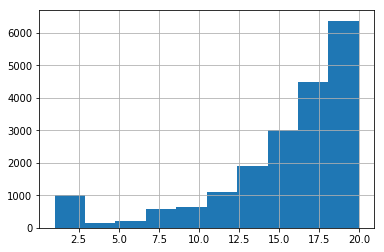

In [120]:
ppls = pd.Series(list(idx2perplexity.values()))
ppls[ppls < 20].hist()

In [121]:
perplexity2idx = dict(zip(idx2perplexity.values(), idx2perplexity.keys()))

In [150]:
# Take a look at 20 sentences with lowest perplexity scores
ppls_sorted = ppls.sort_values()
i = 0
boilerplates = []
bps = []
bp_ppls = []
while len(boilerplates) < 20:
    bp = corpus_sentences[perplexity2idx[ppls_sorted.iloc[i]]]
    if bp not in boilerplates:
        bps.append(bp)
        bp_ppls.append(ppls_sorted.iloc[i])
        boilerplates.append(bp)
    i += 1

In [153]:
pd.DataFrame({'Boilerplate':bps, 'Perplexity':bp_ppls})

,Boilerplate,Perplexity
0,Glebe Rd,0.990099
1,Barack Obama,1.005295
2,Thank you,1.050635
3,Et cetera,1.054870
4,Mm-hmm,1.153213
5,Goldman Sachs,1.212393
6,"Whoah, whoah, whoah, whoah, whoah",1.234568
7,Saudi Arabia,1.256081
8,Forgive me,1.269394
9,Hang on,1.315789
